# Proyecto: Predicción de Alertas Térmicas mediante Aprendizaje Automático

Alumno: Mariano Buet

Se propone desarrollar un modelo de clasificación multiclase que prediga tres tipos de estados térmicos "riesgo de helada, clima de confort y riesgo de sobrecalor" a partir de variables meteorológicas.
El objetivo principal es anticipar condiciones extremas para apoyar la toma de decisiones preventivas en distintos ámbitos: agrícola (proteger cultivos), doméstico (evitar congelamiento de cañerías) e industrial (ajustar sistemas de ventilación o riego)

In [23]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

In [24]:
#Cargo el dataset directamente del Git
url = "https://github.com/MarianoBuet/Aprendizaje-Autom-tico/raw/main/Entregas_Parcial/datos/Estad%C3%ADsticas%20normales%20Datos%20abiertos%201991-2020%20-%20AJUSTADO.xlsx"

df = pd.read_excel(url,header=0)
df.head()

,Estacion,Mes,Dias de Lluvia,Humeda,Nubosidad,Precipitacion,Temp Media,Temp Max,Temp Min,Viento,Objetivo
0,AEROPARQUE AERO,Ene,6.7,67.0,3.1,117.5,24.5,28.4,20.8,16.8,NORMAL
1,AEROPARQUE AERO,Feb,6.0,69.8,3.2,112.3,23.7,27.3,20.2,15.8,NORMAL
2,AEROPARQUE AERO,Mar,5.9,71.3,3.1,111.8,22.0,25.5,18.8,14.9,NORMAL
3,AEROPARQUE AERO,Abr,6.6,73.6,3.5,108.3,18.5,22.0,15.3,13.9,NORMAL
4,AEROPARQUE AERO,May,5.0,76.4,4.0,83.3,15.2,18.4,12.3,12.9,NORMAL


# Analisis Exploratorio del Set de Datos

Estructura General y tipos de variables

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Estacion        1171 non-null   object 
 1   Mes             1171 non-null   object 
 2   Dias de Lluvia  1061 non-null   float64
 3   Humeda          1110 non-null   float64
 4   Nubosidad       1166 non-null   float64
 5   Precipitacion   1061 non-null   float64
 6   Temp Media      1167 non-null   float64
 7   Temp Max        1158 non-null   float64
 8   Temp Min        1124 non-null   float64
 9   Viento          708 non-null    float64
 10  Objetivo        1171 non-null   object 
dtypes: float64(8), object(3)
memory usage: 100.8+ KB


Analisis de los valores nulos

In [26]:
print("\nValores nulos por columna:")
print(df.isnull().sum())


Valores nulos por columna:
Estacion            0
Mes                 0
Dias de Lluvia    110
Humeda             61
Nubosidad           5
Precipitacion     110
Temp Media          4
Temp Max           13
Temp Min           47
Viento            463
Objetivo            0
dtype: int64


Analisis Estadístico Rapido

In [27]:
display(df.describe(percentiles=[0.25,0.5,0.75]).T)

,count,mean,std,min,25%,50%,75%,max
Dias de Lluvia,1061.0,5.097455,2.536586,0.0,3.100,5.2,7.0,13.8
Humeda,1110.0,68.005405,11.027475,25.7,61.325,70.1,76.4,90.2
Nubosidad,1166.0,3.840137,0.888284,1.3,3.300,3.7,4.2,7.5
Precipitacion,1061.0,68.234873,51.674519,0.0,23.300,58.9,106.5,277.9
Temp Media,1167.0,14.834190,8.178787,-20.9,10.300,15.7,21.2,28.3
Temp Max,1158.0,21.223834,8.938676,-17.5,17.025,22.4,27.9,35.5
Temp Min,1124.0,9.102847,7.778743,-25.0,4.500,9.9,15.1,22.5
Viento,708.0,13.011582,5.554040,3.9,9.200,11.8,15.9,36.5


Analisis de las variables numéricas

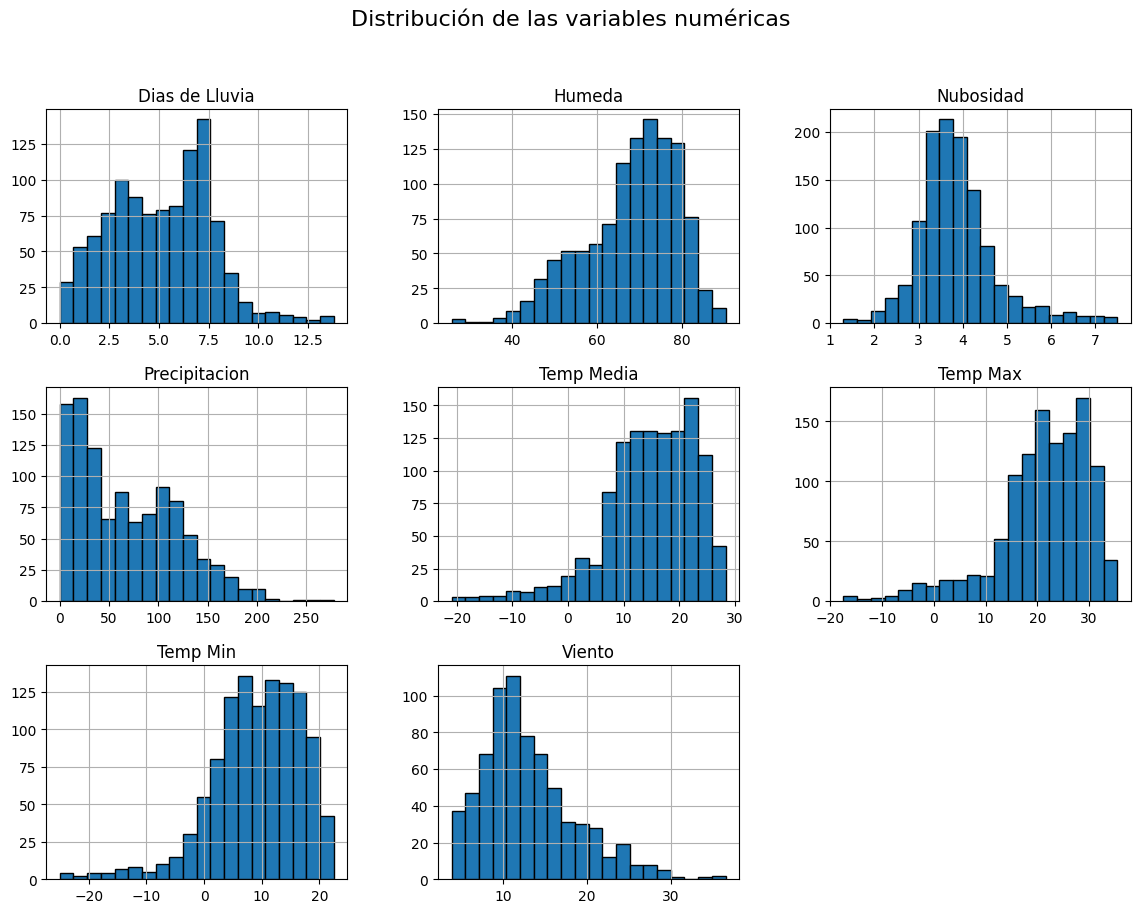

In [28]:
variables_numericas = df.select_dtypes(include=['float64', 'int64']).columns

df[variables_numericas].hist(figsize=(14, 10), bins=20, edgecolor='black')
plt.suptitle("Distribución de las variables numéricas", fontsize=16)
plt.show()

Distribucion de la Variable Objetivo

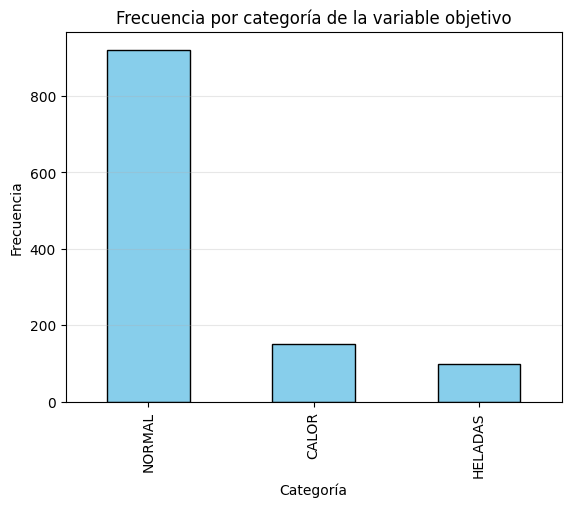

In [29]:


df['Objetivo'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frecuencia por categoría de la variable objetivo')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.3)
plt.show()

Analisis de Correlacion entre Variables y Variable Objetivo - Se excluyen las variables de Temperaturas

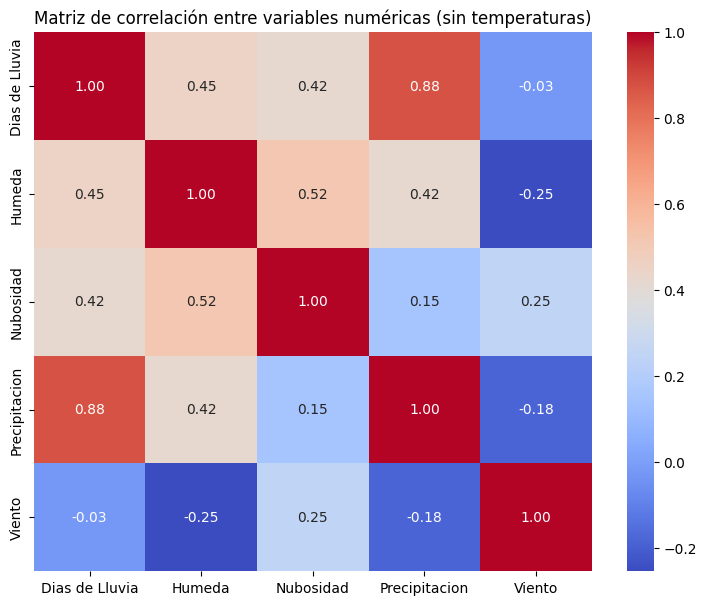

Correlación de cada variable numérica con la variable objetivo:


,Objetivo_num
Precipitacion,-0.261928
Dias de Lluvia,-0.206825
Humeda,0.119638
Nubosidad,-0.068928
Viento,0.027871


/tmp/ipython-input-1143011162.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette="coolwarm")


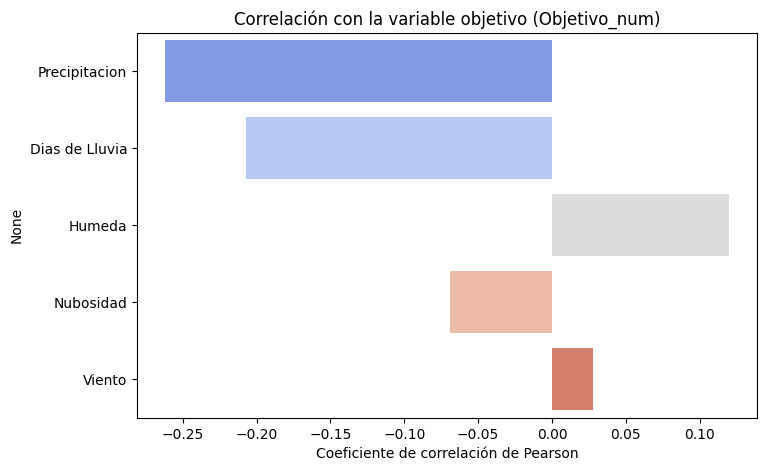

In [30]:
# Matriz de correlación (sin incluir temperaturas)
vars_corr = [c for c in df.select_dtypes(include=[np.number]).columns if "Temp" not in c]
plt.figure(figsize=(9,7))
sns.heatmap(df[vars_corr].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas (sin temperaturas)")
plt.show()

# Copio el DataFrame para no alterar el original
df_corr = df.copy()
df_corr["Objetivo_num"] = df_corr["Objetivo"].astype("category").cat.codes

# Selecciono variables numéricas (sin temperaturas)
num_cols = [c for c in df_corr.select_dtypes(include=[np.number]).columns if "Temp" not in c]

# Calculo correlación con la variable objetivo
correlations = df_corr[num_cols].corr()["Objetivo_num"].drop("Objetivo_num").sort_values(key=np.abs, ascending=False)

# Mostrar resultados ordenados
print("Correlación de cada variable numérica con la variable objetivo:")
display(correlations)

# Visualización
plt.figure(figsize=(8,5))
sns.barplot(x=correlations.values, y=correlations.index, palette="coolwarm")
plt.title("Correlación con la variable objetivo (Objetivo_num)")
plt.xlabel("Coeficiente de correlación de Pearson")
plt.show()


# Preprocesamiento

In [31]:

# corregir nombres mal escritos si existen
df = df.rename(columns={"Humeda": "Humedad"})

# Mostrar columnas con nulos
faltantes = df.isnull().sum()
faltantes = faltantes[faltantes > 0]
if faltantes.empty:
    print("No hay valores nulos en el dataset.")
else:
    print("Columnas con valores nulos:")
    display(faltantes)

#Realizo tratamiento de valores nulos aplicando moda, mediana o media segun fuera

#Definir columnas por método
cols_media   = [c for c in ["Temp Media","Viento","Dias de Lluvia"] if c in df.columns]
cols_mediana = [c for c in ["Humedad","Precipitacion"] if c in df.columns]
cols_moda    = [c for c in ["Temp Min","Temp Max","Nubosidad"] if c in df.columns]

# Aplicar MEDIA
for col in cols_media:
    mean_value = df[col].mean()
    df[col] = df[col].fillna(mean_value)
    print(f"Columna '{col}' completada con la MEDIA ({mean_value:.2f})")

# Aplicar MEDIANA
for col in cols_mediana:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)
    print(f"Columna '{col}' completada con la MEDIANA ({median_value:.2f})")

# Aplicar MODA
for col in cols_moda:
    moda_series = df[col].mode(dropna=True)
    if len(moda_series) > 0:
        moda_val = moda_series.iloc[0]
        df[col] = df[col].fillna(moda_val)
        print(f"Columna '{col}' completada con la MODA ({moda_val})")
    else:
        print(f"Columna '{col}' no tiene suficiente información para calcular la moda")

# Verificación final
faltantes_final = df.isnull().sum()
if faltantes_final.sum() == 0:
    print("\n Todas las columnas quedaron completas, sin valores nulos.")
else:
    print("\n Aún quedan valores nulos en las siguientes columnas:")
    print(faltantes_final[faltantes_final > 0])

#Ajusto el set de datos para exlcuir las variables termicas

cols_excluir = ["Temp Media", "Temp Max", "Temp Min", "Objetivo", "Objetivo_num"]
X = df.drop(columns=[c for c in cols_excluir if c in df.columns])
y = df["Objetivo"]

# Ver mapeo de la variable objetivo
y_cat = y.astype("category")
print("\n Codificación automática (código → categoría):")
for code, cat in enumerate(y_cat.cat.categories):
    print(f"  {code} → {cat}")

df["Objetivo_num"] = y_cat.cat.codes  # solo para inspección (no se usa en X)

#Codifico las variables categoricas
num_cols = X.select_dtypes(include=["int64","float64"]).columns
cat_cols = X.select_dtypes(exclude=["int64","float64"]).columns

X = pd.get_dummies(X, columns=cat_cols, drop_first=True, dtype=int)


#Realizo Escalamiento de variables

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

print("\n Columnas originales categóricas:"); print(list(cat_cols))
print("\n Columnas nuevas generadas por get_dummies:");
dummies_cols = [c for c in X.columns if any(cat in c for cat in cat_cols)]
print(dummies_cols[:30])
print("\n Primeras filas del dataset codificado:"); display(X.head())
print(f"\nTotal de columnas después de codificar: {X.shape[1]}")

Columnas con valores nulos:


,0
Dias de Lluvia,110
Humedad,61
Nubosidad,5
Precipitacion,110
Temp Media,4
Temp Max,13
Temp Min,47
Viento,463


Columna 'Temp Media' completada con la MEDIA (14.83)
Columna 'Viento' completada con la MEDIA (13.01)
Columna 'Dias de Lluvia' completada con la MEDIA (5.10)
Columna 'Humedad' completada con la MEDIANA (70.10)
Columna 'Precipitacion' completada con la MEDIANA (58.90)
Columna 'Temp Min' completada con la MODA (4.9)
Columna 'Temp Max' completada con la MODA (27.9)
Columna 'Nubosidad' completada con la MODA (3.7)

 Todas las columnas quedaron completas, sin valores nulos.

 Codificación automática (código → categoría):
  0 → CALOR
  1 → HELADAS
  2 → NORMAL

 Columnas originales categóricas:
['Estacion', 'Mes']

 Columnas nuevas generadas por get_dummies:
['Estacion_AZUL AERO*', 'Estacion_BAHÃ\x8dA BLANCA AERO', 'Estacion_BARILOCHE AERO', 'Estacion_BASE BELGRANO II', 'Estacion_BASE CARLINI (EX JÃšBANY)', 'Estacion_BASE ESPERANZA', 'Estacion_BASE MARAMBIO', 'Estacion_BASE ORCADAS', 'Estacion_BASE SAN MARTÃ\x8dN', 'Estacion_BERNARDO DE IRIGOYEN AERO', 'Estacion_BOLÃ\x8dVAR AERO', 'Estacion_

,Dias de Lluvia,Humedad,Nubosidad,Precipitacion,Viento,Estacion_AZUL AERO*,Estacion_BAHÃA BLANCA AERO,Estacion_BARILOCHE AERO,Estacion_BASE BELGRANO II,Estacion_BASE CARLINI (EX JÃšBANY),...,Mes_Dic,Mes_Ene,Mes_Feb,Mes_Jul,Mes_Jun,Mes_Mar,Mes_May,Mes_Nov,Mes_Oct,Mes_Sep
0,0.664028,-0.103757,-0.834644,1.018323,0.877845,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.373977,0.156911,-0.721784,0.912717,0.646127,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.332541,0.296554,-0.834644,0.902563,0.437580,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.622592,0.510674,-0.383204,0.831482,0.205862,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.040381,0.771341,0.181097,0.323763,-0.025856,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0



Total de columnas después de codificar: 113


In [32]:
print("\nValores nulos por columna:")
print(df.isnull().sum())


Valores nulos por columna:
Estacion          0
Mes               0
Dias de Lluvia    0
Humedad           0
Nubosidad         0
Precipitacion     0
Temp Media        0
Temp Max          0
Temp Min          0
Viento            0
Objetivo          0
Objetivo_num      0
dtype: int64


# División del dataset en Entrenamiento y Test

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


 Accuracy: 0.872

 Matriz de Confusión:
[[ 28   0   2]
 [  0  20   0]
 [ 20   8 157]]

 Reporte de Clasificación:
              precision    recall  f1-score   support

       CALOR       0.58      0.93      0.72        30
     HELADAS       0.71      1.00      0.83        20
      NORMAL       0.99      0.85      0.91       185

    accuracy                           0.87       235
   macro avg       0.76      0.93      0.82       235
weighted avg       0.91      0.87      0.88       235



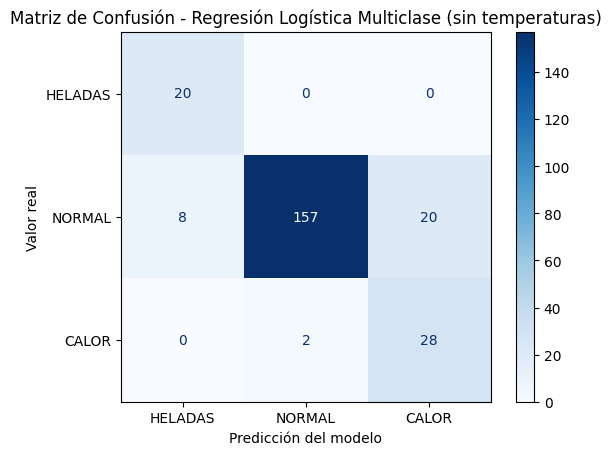

In [33]:

# Regresión Logística Multiclase - sin Temp Media/Max/Min


# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenamiento
log_model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000,
    random_state=42,
    class_weight="balanced"
)
log_model.fit(X_train, y_train)

# Predicciones y métricas
y_pred = log_model.predict(X_test)

print(" Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\n Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\n Reporte de Clasificación:")
print(classification_report(y_test, y_pred))



labels = ["HELADAS", "NORMAL", "CALOR"]

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d")

plt.title("Matriz de Confusión - Regresión Logística Multiclase (sin temperaturas)")
plt.xlabel("Predicción del modelo")
plt.ylabel("Valor real")
plt.show()

 Top 20 variables más influyentes en la predicción:


,Variable,Importancia (abs)
8,Estacion_BASE BELGRANO II,1.734384
37,Estacion_GOBERNADOR GREGORES AERO*,1.374605
24,Estacion_CORONEL SUÃREZ AERO,1.335117
51,Estacion_MAQUINCHAO,1.263232
104,Mes_Ene,1.221643
61,Estacion_ORÃN AERO*,1.092702
17,Estacion_CATAMARCA AERO,1.007794
105,Mes_Feb,1.002475
92,Estacion_TINOGASTA,1.000537
91,Estacion_TARTAGAL AERO,0.963896


/tmp/ipython-input-2710674283.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Variable", x="Importancia (abs)", data=coef.head(20), palette="coolwarm")
/tmp/ipython-input-2710674283.py:16: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2710674283.py:16: UserWarning: Glyph 141 (\x8d) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 141 (\x8d) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


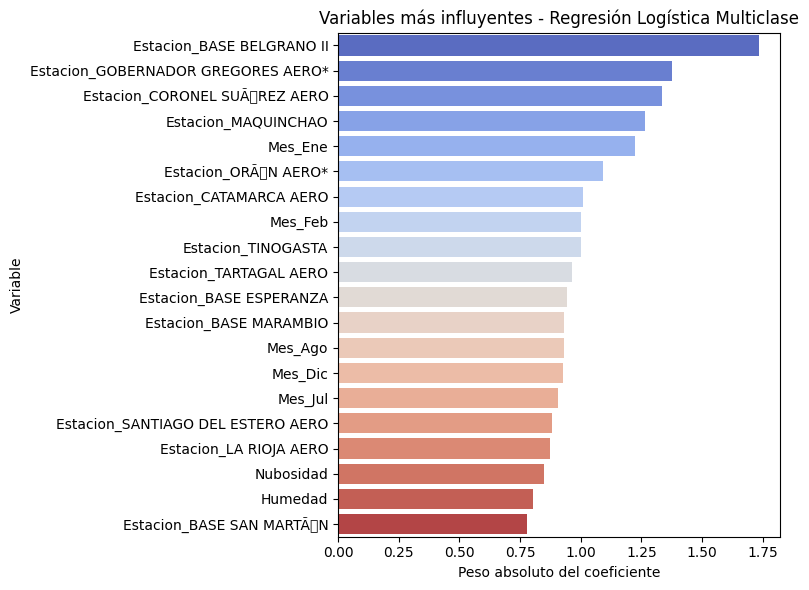

In [34]:
# Importancia de las variables


coef = pd.DataFrame({
    "Variable": X.columns,
    "Importancia (abs)": np.mean(np.abs(log_model.coef_), axis=0)
}).sort_values(by="Importancia (abs)", ascending=False)

print(" Top 20 variables más influyentes en la predicción:")
display(coef.head(20))

plt.figure(figsize=(8,6))
sns.barplot(y="Variable", x="Importancia (abs)", data=coef.head(20), palette="coolwarm")
plt.title("Variables más influyentes - Regresión Logística Multiclase")
plt.xlabel("Peso absoluto del coeficiente")
plt.tight_layout()
plt.show()